## Compare filters

In [2]:
%reset
import sys
sys.path.append('/home/eay8226/gcm-filters')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from gcm_filters import filter
from gcm_filters.kernels import GridType
from vorticity import compute_vorticity
import cmocean

In [3]:
import os
print(os.getcwd())


/home/arthur/python/NYU/gcm-filters/mom5_example


Script parameters

In [4]:
# region
# lats = slice(-50, -30)
# lons = slice(20, 40)
# latsT = slice(-50, -29.9)
# lonsT = slice(20, 40)
lats = slice(0., 60.)
lons = slice(-240, -180)
latsT = slice(0., 60.)
lonsT = slice(-240., -180.)

cmap='Spectral'
vmax=0.2
vmin=-vmax

plt_args = dict(vmin=vmin, vmax=vmax, cmap=cmap)

In [22]:
from read_data import read_data
data_location = '/scratch/ag7531/shareElizabeth/'
grid_filename = 'grid_dataforeli'
uv_filename = 'uv_dataforeli'

grid_data, data = read_data(data_location, uv_filename, grid_filename)
grid_data = grid_data.compute().reset_coords()
data = data[['usurf', 'vsurf']].sel(xu_ocean=lons, yu_ocean=lats).isel(time=0)
data_saved = data
grid_data_save = grid_data
print('done')

done


Problem: we need the grid vars to be on the same grid as the field to
be filtered. Here I've interpolated, but I think this is not right,
we can probably just redefine the coords of dxt and dyt to be those of the
velocities, we'll just have to be careful.

In [23]:
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u','wet']]
# Here we need dxt and dyt to be on the velocity grid
velocity_coords = grid_data[['yu_ocean', 'xu_ocean']]
grid_data['dxt'] = xr.DataArray(data=grid_data['dxt'],
                                dims=('yu_ocean', 'xu_ocean'),
                                coords=velocity_coords)
grid_data['dyt'] = xr.DataArray(data=grid_data['dyt'],
                                dims=('yu_ocean', 'xu_ocean'),
                                coords=velocity_coords)
grid_data['wet'] = xr.DataArray(data=grid_data['wet'],
                                dims=('yu_ocean', 'xu_ocean'),
                                coords=velocity_coords)
grid_data = grid_data.sel(xu_ocean=lons, yu_ocean=lats)
del grid_data['xt_ocean']
del grid_data['yt_ocean']
print(grid_data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 600, yu_ocean: 755)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.569e+03
    dyt       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.569e+03
    dxu       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.564e+03
    dyu       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.564e+03
    area_u    (yu_ocean, xu_ocean) float32 1.236e+08 1.236e+08 ... 3.096e+07
    wet       (yu_ocean, xu_ocean) float64 0.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    NCO:      4.0.3


In [24]:
grid_dataT = grid_data_save[['dxt', 'dyt', 'dxu', 'dyu', 'area_t','wet']]
tracer_coords = grid_dataT[['yt_ocean', 'xt_ocean']]

grid_dataT['dxu'] = xr.DataArray(data=grid_dataT['dxu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT['dyu'] = xr.DataArray(data=grid_dataT['dyu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT = grid_dataT.sel(xt_ocean=lonsT, yt_ocean=latsT)
del grid_dataT['xu_ocean']
del grid_dataT['yu_ocean']

print(grid_dataT)

<xarray.Dataset>
Dimensions:   (xt_ocean: 600, yt_ocean: 755)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -239.9 -239.8 -239.7 ... -180.2 -180.1 -180.0
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 59.85 59.9 59.95 60.0
Data variables:
    dxt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.56e+03
    dyt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.56e+03
    dxu       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.556e+03
    dyu       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.556e+03
    area_t    (yt_ocean, xt_ocean) float32 1.236e+08 1.236e+08 ... 3.092e+07
    wet       (yt_ocean, xt_ocean) float64 0.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    NCO:      4.0.3


Create the filter and print its specs

In [25]:
dx_min = np.min(grid_data['dxt'].values)
mom5_filterU = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_data,
                                 grid_type=GridType.MOM5U)


mom5_filterT = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_dataT,
                                 grid_type=GridType.MOM5T)

Compute the vorticity field

In [26]:
data = data.sel(yu_ocean=lats, xu_ocean=lons)

vorticity = compute_vorticity(data, grid_dataT)

In [27]:
print(vorticity.shape)
print(data['xu_ocean'].shape)

(755, 600)
(600,)


In [28]:
print(vorticity)


<xarray.DataArray (yt_ocean: 755, xt_ocean: 600)>
array([[ 4.64749539e-310,  4.64749480e-310,  4.64749539e-310, ...,
         5.23154807e+121,  2.45563954e+238,  5.54508920e+121],
       [ 1.15815032e-071,              nan,              nan, ...,
         8.75151384e-007,  5.40419381e-007,  1.46793818e+171],
       [ 7.03363963e+117,              nan,              nan, ...,
        -8.89766145e-007, -4.01920826e-007,  1.59099465e+064],
       ...,
       [             nan,              nan,              nan, ...,
         5.59530983e-006,  3.37581211e-006, -1.82050000e+002],
       [-1.81950000e+002,              nan,              nan, ...,
         7.29070158e-006,  3.48435434e-006, -1.82050000e+002],
       [-1.81950000e+002, -1.81850000e+002, -1.81750000e+002, ...,
        -1.82250000e+002, -1.82150000e+002, -1.82050000e+002]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 59.85 59.9 59.95 60.0
  * xt_ocean  (xt_ocean) float64 -239.9 -239.8 -239.7 ... -180.2 

In [29]:
print(data['usurf'])

<xarray.DataArray 'usurf' (yu_ocean: 755, xu_ocean: 600)>
dask.array<getitem, shape=(755, 600), dtype=float32, chunksize=(755, 600), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_c
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-10.0, 10.0]


Carry out filtering operation

In [30]:
filtered_vorticity = mom5_filterT.apply(vorticity, dims=['yt_ocean',
                                                         'xt_ocean'])

/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:137: RuntimeWarning: invalid value encountered in true_divide
  out1 /= self.area_t
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:143: RuntimeWarning: divide by zero encountered in true_divide
  out2 /= self.area_t
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:143: RuntimeWarning: invalid value encountered in true_divide
  out2 /= self.area_t


In [31]:
print('done')

done


<ipython-input-32-e8864792d2a6>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);


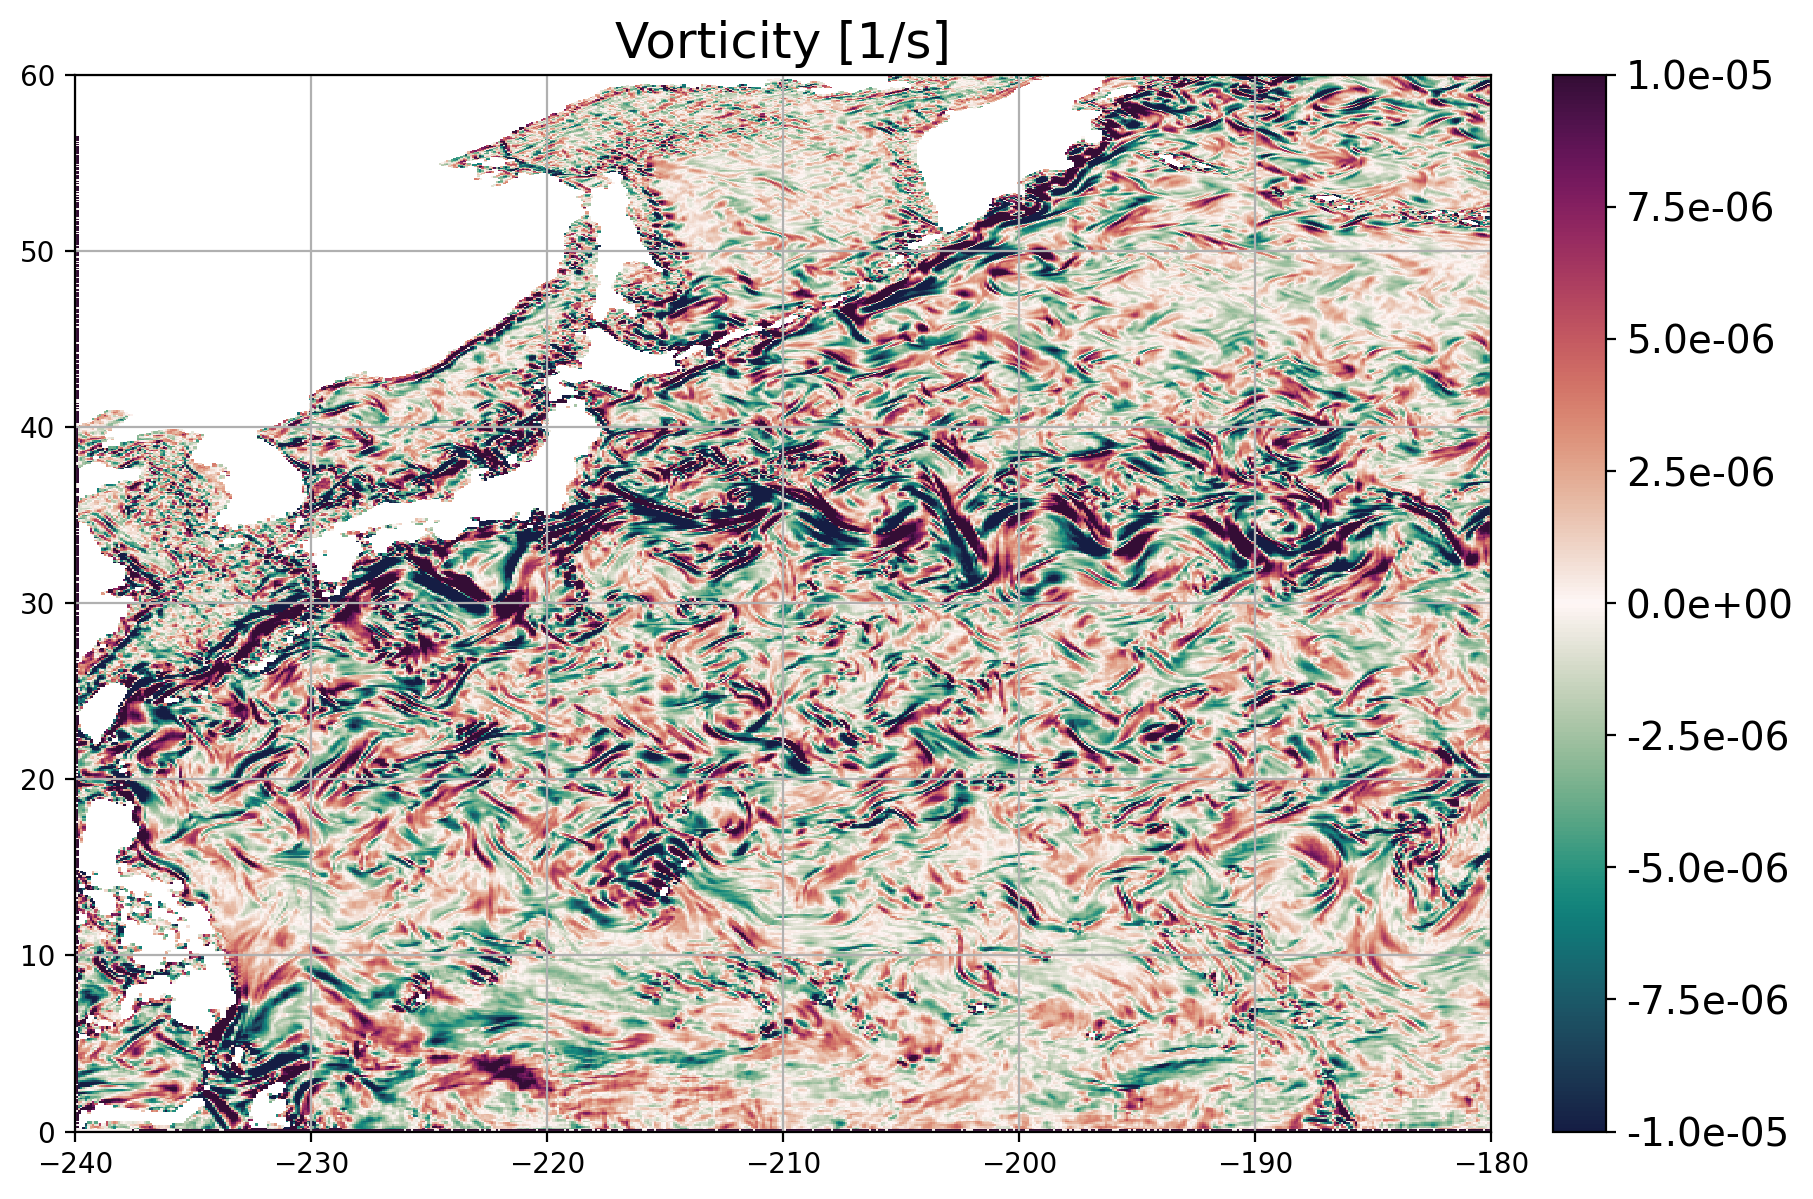

In [32]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Vorticity [1/s]',fontsize=18) #positive into ocean
plt.show()

<ipython-input-33-abd6280c2016>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],filtered_vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);


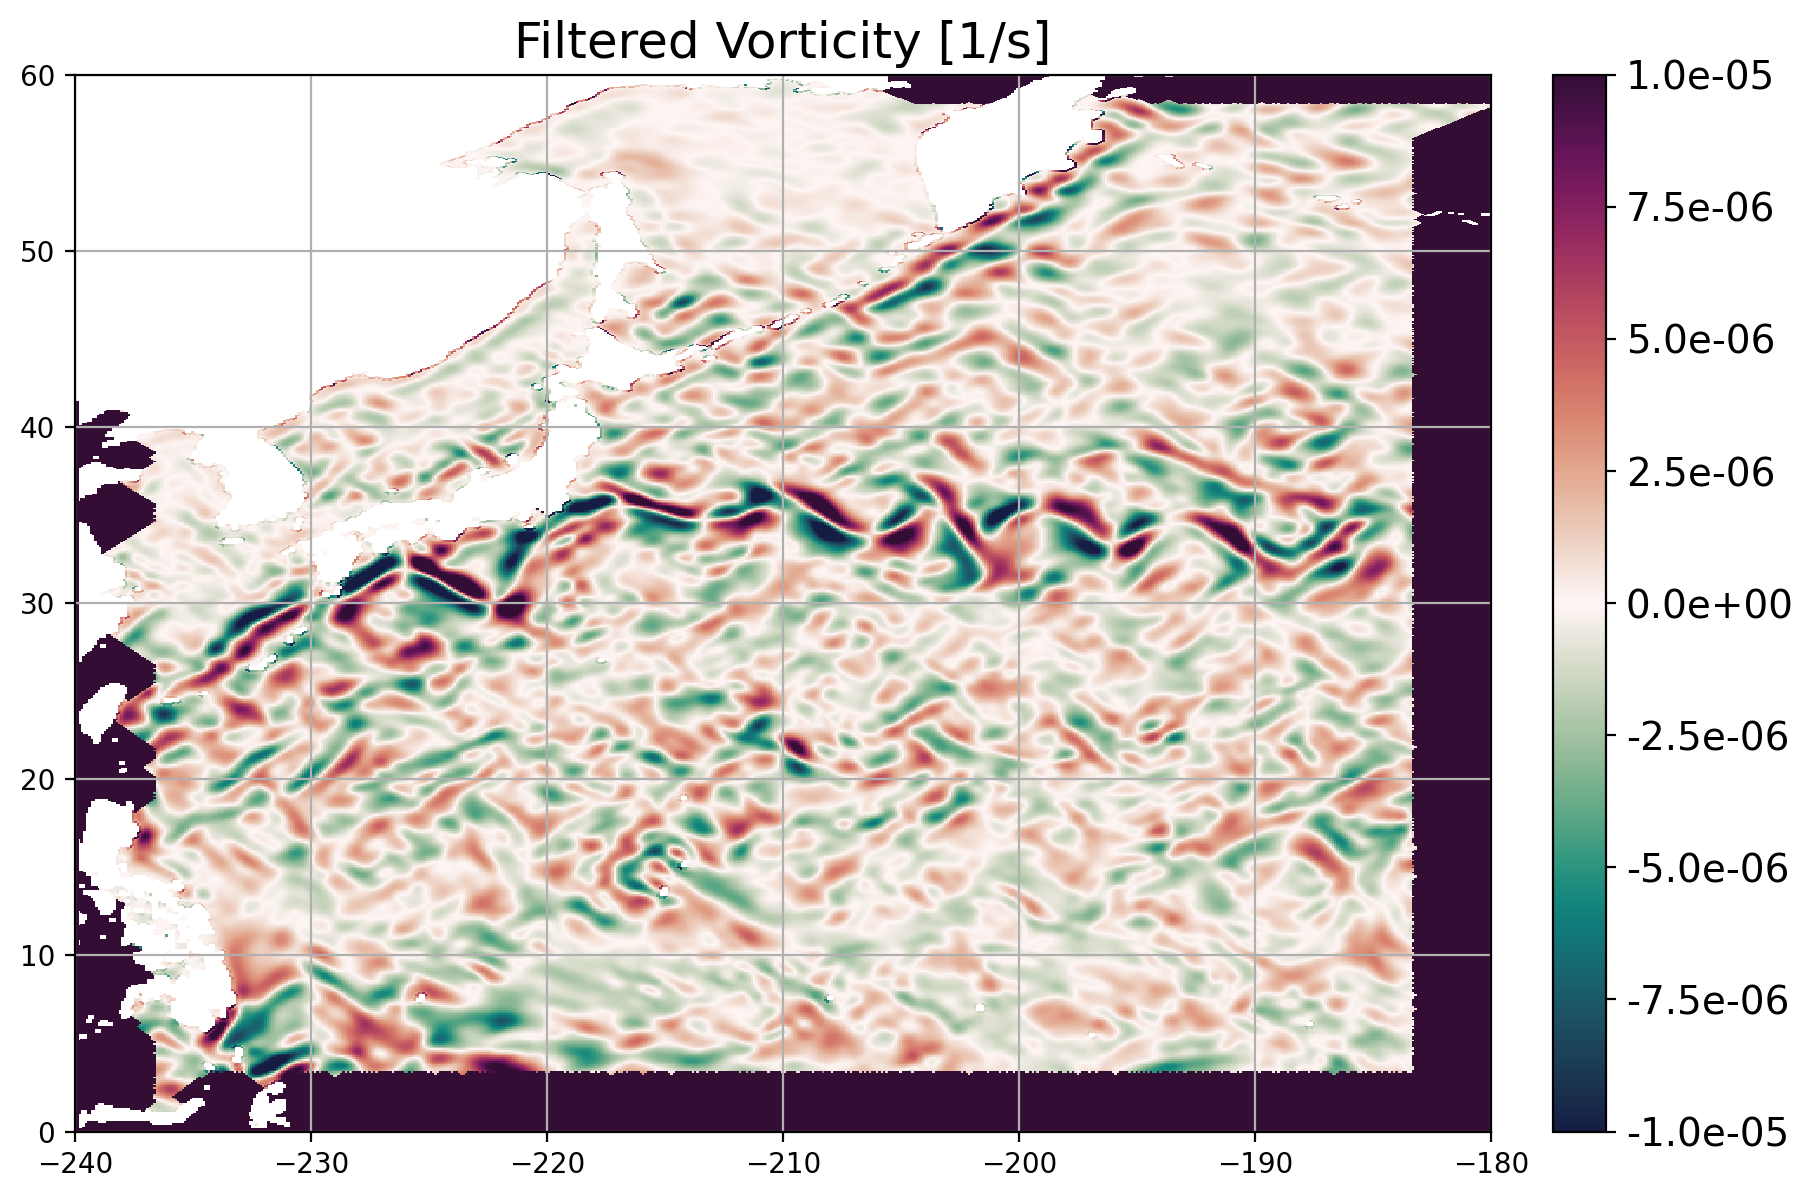

In [33]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')


plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],filtered_vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Filtered Vorticity [1/s]',fontsize=18) #positive into ocean
plt.show()

In [34]:
print(data['usurf'])

<xarray.DataArray 'usurf' (yu_ocean: 755, xu_ocean: 600)>
dask.array<getitem, shape=(755, 600), dtype=float32, chunksize=(755, 600), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_c
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-10.0, 10.0]


In [35]:
print(mom5_filterU.grid_vars)

<xarray.Dataset>
Dimensions:   (xu_ocean: 600, yu_ocean: 755)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.569e+03
    dyt       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.569e+03
    dxu       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.564e+03
    dyu       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.564e+03
    area_u    (yu_ocean, xu_ocean) float32 1.236e+08 1.236e+08 ... 3.096e+07
    wet       (yu_ocean, xu_ocean) float64 0.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    NCO:      4.0.3


Filter the velocities

In [38]:
u_filtered = mom5_filterU.apply(data['usurf'], ['yu_ocean', 'xu_ocean'])
v_filtered = mom5_filterU.apply(data['vsurf'], ['yu_ocean', 'xu_ocean'])

#u_filtered = mom5_filterU.apply(data['usurf'], dims=['yu_ocean',
                                                         #'xu_ocean'])
print(data['usurf'])

<xarray.DataArray 'usurf' (yu_ocean: 755, xu_ocean: 600)>
dask.array<getitem, shape=(755, 600), dtype=float32, chunksize=(755, 600), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_c
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-10.0, 10.0]


Compute the vorticity of the filtered velocity field

In [39]:
uv_filtered = xr.Dataset(dict(usurf=u_filtered, vsurf=v_filtered))

vorticity_filtereduv = compute_vorticity(uv_filtered, grid_dataT)

/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:93: RuntimeWarning: invalid value encountered in true_divide
  out1 /= self.area_u
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:99: RuntimeWarning: divide by zero encountered in true_divide
  out2 /= self.area_u
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:99: RuntimeWarning: invalid value encountered in true_divide
  out2 /= self.area_u
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:93: RuntimeWarning: invalid value encountered in true_divide
  out1 /= self.area_u
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:99: RuntimeWarning: divide by zero encountered in true_divide
  out2 /= self.area_u
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:99: RuntimeWarning: invalid value encountered in true_divide
  out2 /= self.area_u


In [40]:
print(vorticity_filtereduv)

<xarray.DataArray (yt_ocean: 755, xt_ocean: 600)>
array([[ 4.64749516e-310,  4.64749390e-310,  0.00000000e+000, ...,
         1.00000000e+000,  1.00000000e+000,  1.00000000e+000],
       [ 0.00000000e+000,              nan,              nan, ...,
        -5.43643240e-006, -8.36323738e-006,  1.00000000e+000],
       [ 0.00000000e+000,              nan,              nan, ...,
        -5.85452361e-006, -9.10313924e-006,  1.00000000e+000],
       ...,
       [ 0.00000000e+000,              nan,              nan, ...,
        -6.76428781e-006, -8.50384625e-006,  1.00000000e+000],
       [ 0.00000000e+000,              nan,              nan, ...,
        -7.82667395e-006, -1.02782230e-005,  1.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         1.00000000e+000,  1.00000000e+000,  1.00000000e+000]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 59.85 59.9 59.95 60.0
  * xt_ocean  (xt_ocean) float64 -239.9 -239.8 -239.7 ... -180.2 

<ipython-input-41-0252130c7e48>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity_filtereduv,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);


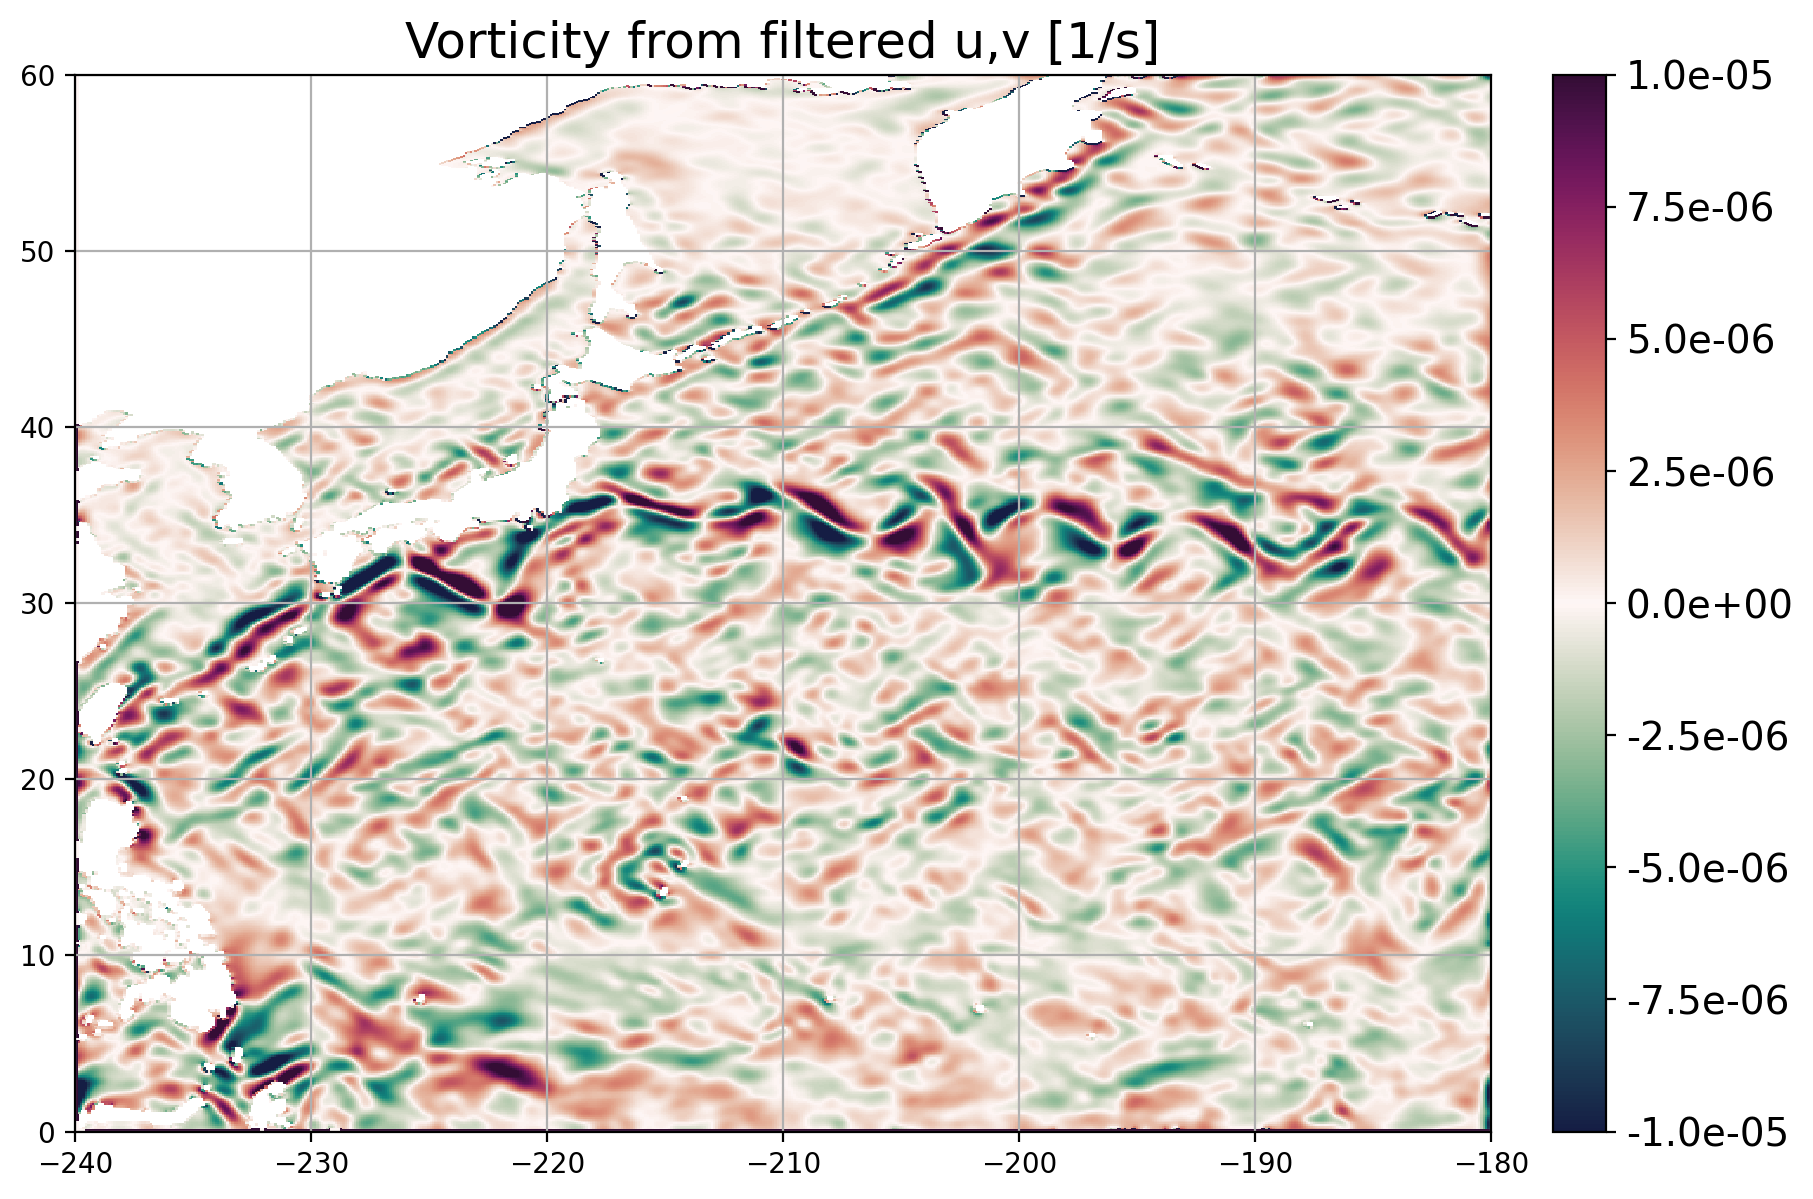

In [41]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity_filtereduv,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Vorticity from filtered u,v [1/s]',fontsize=18) #positive into ocean
plt.show()

In [19]:
a = np.empty((3,3,))

In [20]:
print(a)

[[4.9e-324 9.9e-324 1.5e-323]
 [2.0e-323 2.5e-323 3.0e-323]
 [3.5e-323 4.0e-323 4.4e-323]]
